## Analyse the performance curve

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import ipdb
import re
import seaborn as sns
import pandas as pd
from pprint import pprint
%matplotlib inline

In [ ]:
models = ['HRED', 'MReCoSa', 'MTGCN', 'GatedGCN']    # Add GATRNN
dataset_name = 'dailydialog'
paths = [f'./processed/{dataset_name}/{i}/conclusion.txt' for i in models]
size = 30

In [ ]:
def read_file(path, size=30):
    with open(path) as f:
        bleu1, bleu2, bleu3, bleu4, rouge, dist1, dist2 = [], [], [], [], [], [], []
        EA, VX, GM = [], [], []
        for line in f.readlines():
            line = line.strip()
            if 'BLEU-1' in line:
                bleu1.append(float(line.replace('BLEU-1: ', '')))
            elif 'BLEU-2' in line:
                bleu2.append(float(line.replace('BLEU-2: ', '')))
            elif 'BLEU-3' in line:
                bleu3.append(float(line.replace('BLEU-3: ', '')))
            elif 'BLEU-4' in line:
                bleu4.append(float(line.replace('BLEU-4: ', '')))
            elif 'ROUGE' in line:
                rouge.append(float(line.replace('ROUGE: ', '')))
            elif 'Distinct' in line:
                distinct1, distinct2 = line.split(';')
                dist1.append(float(distinct1.replace('Distinct-1: ', '').strip()))
                dist2.append(float(distinct2.replace('Distinct-2: ', '').strip()))
            elif 'EA' in line:
                EA.append(float(line.replace('EA: ', '')))
            elif 'VX' in line:
                VX.append(float(line.replace('VX: ', '')))
            # elif 'GM' in line:
            #     GM.append(float(line.replace('GM: ', '')))
    assert len(bleu1) == size, f'{len(bleu1)} -- {size}'
    assert len(bleu2) == size, f'{len(bleu2)} -- {size}'
    assert len(bleu3) == size, f'{len(bleu3)} -- {size}'
    assert len(bleu4) == size, f'{len(bleu4)} -- {size}'
    assert len(rouge) == size, f'{len(rouge)} -- {size}'
    assert len(dist1) == size, f'{len(dist1)} -- {size}'
    assert len(dist2) == size, f'{len(dist2)} -- {size}'
    assert len(EA) == size, f'{len(EA)} -- {size}'
    assert len(VX) == size, f'{len(VX)} -- {size}'
    # assert len(GM) == size, f'{len(GM)} -- {size}'
    return (bleu1, bleu2, bleu3, bleu4, rouge, dist1, dist2, EA, VX)

In [ ]:
def draw_curve(ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9,
               bleu1, bleu2, bleu3, bleu4, rouge, dist1, dist2, ea, vx, m):
    x = np.arange(1, size + 1)
    
    ax1.plot(x, bleu1, label=m)
    ax1.legend()
    ax1.set_title('BLEU-1')
    
    ax2.plot(x, bleu2, label=m)
    ax2.legend()
    ax2.set_title('BLEU-2')
    
    ax3.plot(x, bleu3, label=m)
    ax3.legend()
    ax3.set_title('BLEU-3')
    
    ax4.plot(x, bleu4, label=m)
    ax4.legend()
    ax4.set_title('BLEU-4')
    
    ax5.plot(x, rouge, label=m)
    ax5.legend()
    ax5.set_title('ROUGE')
    
    ax6.plot(x, dist1, label=m)
    ax6.legend()
    ax6.set_title('Distinct-1')
    
    ax7.plot(x, dist2, label=m)
    ax7.legend()
    ax7.set_title('Distinct-2')
    
    ax8.plot(x, ea, label=m)
    ax8.legend()
    ax8.set_title('Embedding Average')
    
    ax9.plot(x, vx, label=m)
    ax9.legend()
    ax9.set_title('Vector Extrema')

In [ ]:
def meta_data(bar, data):
    try:
        print(f'{bar}: Max data {np.max(data)}, epoch: {1 + np.argmax(data)}')
    except:
        return 

In [ ]:
dataset = []
for m, path in zip(models, paths):
    print(f'========== {m} : {path} ==========')
    data = read_file(path, size=size)
    if data:
        dataset.append(data)
        meta_data('BLEU-1', data[0])
        meta_data('BLEU-2', data[1])
        meta_data('BLEU-3', data[2])
        meta_data('BLEU-4', data[3])
        meta_data('ROUGE',  data[4])
        meta_data('Dist-1', data[5])
        meta_data('Dist-2', data[6])
        meta_data('Embedding Average', data[7])
        meta_data('Vector Extrema', data[8])
        # meta_data('Greedy Matching', data[9])

In [ ]:
plt.figure(figsize=(10, 20))
sub = [plt.subplot(5, 2, 1), plt.subplot(5, 2, 2), plt.subplot(5, 2, 3),
       plt.subplot(5, 2, 4), plt.subplot(5, 2, 5), plt.subplot(5, 2, 6), 
       plt.subplot(5, 2, 7), plt.subplot(5, 2, 8), plt.subplot(5, 2, 9),]

for d, m in zip(dataset, models):
    draw_curve(*sub, *d, m)
    
plt.savefig(f'./img/{dataset_name}.png')

## Show the PPL Perturbation

In [75]:
models = ['HRED', 'DSHRED', 'WSeq', 'MReCoSa', 'VHRED', 
          'HRAN', 'DSHRED_RA', 'WSeq_RA', 'MReCoSa_RA',
          'Seq2Seq', 'Seq2Seq_MHA']    # Add GATRNN
dataset_name = 'empchat'
paths = [f'./processed/{dataset_name}/{i}/pertub-ppl.txt' for i in models]

model = 'HRED'
path = paths[models.index(model)]

In [76]:
def read_ppl(path):
    real = re.compile(r'.*loss: (\w+\.\w+), PPL: (\w+\.\w+).*')
    with open(path) as f:
        loss, ppl = [], []
        for line in f.readlines():
            line = line.strip()
            loss_, ppl_ = real.findall(line)[0]
            loss_, ppl_ = float(loss_), float(ppl_)
            loss.append(loss_)
            ppl.append(ppl_)
    return loss, ppl

In [77]:
loss, ppl = read_ppl(path)
# ppl[4] = ppl[0] + 300
data = pd.DataFrame.from_dict({model: ppl}, orient='index', 
                              columns=['Origin', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
data

,Origin,1,2,3,4,5,6,7,8,9,10
HRED,46.8289,66.1616,68.5251,55.5454,118.7476,57.5757,51.3672,52.3525,51.1417,48.5309,48.74


Whole Perbuturbation:
 [0.0, 19.3327, 21.6962, 8.7165, 71.9187, 10.7468, 4.5383, 5.5236, 4.3128, 1.702, 1.9111]
Max Perturbation: 71.9187, 4
Min Perturbation: 1.702, 9
Mean Perturbation: 15.0399


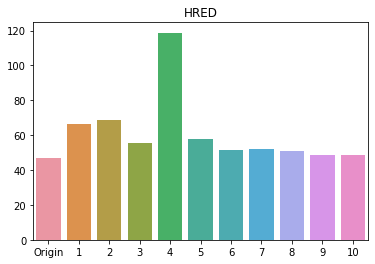

In [78]:
sns.barplot(data=data)
plt.title(f'{model}')
plt.savefig(f'./img/{dataset_name}-{model}-perturbation.png')

# show the count of the perturbation
count = np.array(ppl) - np.array([ppl[0]] * len(ppl))
count = count.tolist()
count = [round(i, 4) for i in count]
print(f'Whole Perbuturbation:\n {count}')
print(f'Max Perturbation: {round(max(count[1:]), 4)}, {np.argmax(count[1:])+1}')
print(f'Min Perturbation: {round(min(count[1:]), 4)}, {np.argmin(count[1:])+1}')
print(f'Mean Perturbation: {round(np.mean(count[1:]), 4)}')

### Dailydialog
Seq2Seq

Seq2Seq-MHA
Whole Perbuturbation:
 [0.0, 15.8091, 21.7254, -6.5134, 69.357, 12.4842, 2.1211, 9.3529, -3.0175, -7.2258, -7.7631]
Max Perturbation: 69.357, 4
Min Perturbation: -7.7631, 10
Mean Perturbation: 10.633

HRED:

WSeq:

VHRED:

DSHRED:
Whole Perbuturbation:
 [0.0, 27.8725, 37.6236, 3.0022, 84.5578, 12.2294, 16.3333, 21.6096, 9.6054, 5.9065, 5.1542]
Max Perturbation: 84.5578, 4
Min Perturbation: 3.0022, 3
Mean Perturbation: 22.3894
    
ReCoSa
    
HRAN

DSHRED-WA
Whole Perbuturbation:
 [0.0, 30.8531, 38.351, 5.1927, 73.8188, 18.9551, 20.9557, 27.8234, 12.4998, 10.5894, 7.9644]
Max Perturbation: 73.8188, 4
Min Perturbation: 5.1927, 3
Mean Perturbation: 24.7003

WSeq-WA

ReCoSa-WA

### EmpChat
Seq2Seq
Whole Perbuturbation:
 [0.0, 14.0162, 23.2781, 10.9458, 73.1184, 13.553, 3.7706, 4.3257, 4.7365, 2.652, 2.9049]
Max Perturbation: 73.1184, 4
Min Perturbation: 2.652, 9
Mean Perturbation: 15.3301

Seq2Seq-MHA

HRED:
Whole Perbuturbation:
 [0.0, 19.3327, 21.6962, 8.7165, 71.9187, 10.7468, 4.5383, 5.5236, 4.3128, 1.702, 1.9111]
Max Perturbation: 71.9187, 4
Min Perturbation: 1.702, 9
Mean Perturbation: 15.0399

WSeq:

VHRED:

DSHRED:
    
ReCoSa
    
HRAN
Whole Perbuturbation:
 [0.0, 20.8905, 23.7996, 10.4145, 68.1211, 13.2406, 7.1619, 10.0035, 6.6166, 3.3192, 2.9016]
Max Perturbation: 68.1211, 4
Min Perturbation: 2.9016, 10
Mean Perturbation: 16.6469

DSHRED-WA

WSeq-WA

ReCoSa-WA

#### PersonaChat
Seq2Seq

Seq2Seq-MHA

HRED

WSeq:

VHRED:

DSHRED:
    
ReCoSa
    
HRAN

DSHRED-WA

WSeq-WA

ReCoSa-WA

#### DSTC7
Seq2Seq

Seq2Seq-MHA

HRED

WSeq:

VHRED:

DSHRED:
    
ReCoSa
    
HRAN

DSHRED-WA

WSeq-WA

ReCoSa-WA

#### Ubuntu
Seq2Seq

Seq2Seq-MHA

HRED

WSeq:

VHRED:

DSHRED:
    
ReCoSa
    
HRAN

DSHRED-WA

WSeq-WA

ReCoSa-WA